# **In the task of sentiment analysis, we automatically classify text data based on polarity—such as positive, negative, neutral, and irrelevant. Companies leverage sentiment analysis of tweets to understand how customers are discussing their products and services, gather insights to guide business decisions, and identify product issues or potential PR crises at an early stage.**

In [81]:

import re
import numpy as np
import pandas as pd
# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# nltk
import nltk
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
nltk.download('stopwords')
from xgboost import XGBClassifier
# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report



[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
train_data = pd.read_csv( '/kaggle/input/twitter-entity-sentiment-analysis/twitter_training.csv' )
print('Shape of the twitter traning data :')
print(train_data.shape)

val_data = pd.read_csv( '/kaggle/input/twitter-entity-sentiment-analysis/twitter_validation.csv' )
print('Shape of the twitter validation data : ')
print(val_data.shape)

Shape of the twitter traning data :
(74681, 4)
Shape of the twitter validation data : 
(999, 4)


In [5]:
train_data.head()

2401  Borderlands  Positive  \
0  2401  Borderlands  Positive   
1  2401  Borderlands  Positive   
2  2401  Borderlands  Positive   
3  2401  Borderlands  Positive   
4  2401  Borderlands  Positive   

  im getting on borderlands and i will murder you all ,  
0  I am coming to the borders and I will kill you...     
1  im getting on borderlands and i will kill you ...     
2  im coming on borderlands and i will murder you...     
3  im getting on borderlands 2 and i will murder ...     
4  im getting into borderlands and i can murder y...

In [6]:
val_data.head()

3364   Facebook Irrelevant  \
0   352     Amazon    Neutral   
1  8312  Microsoft   Negative   
2  4371      CS-GO   Negative   
3  4433     Google    Neutral   
4  6273       FIFA   Negative   

  I mentioned on Facebook that I was struggling for motivation to go for a run the other day, which has been translated by Tom’s great auntie as ‘Hayley can’t get out of bed’ and told to his grandma, who now thinks I’m a lazy, terrible person 🤣  
0  BBC News - Amazon boss Jeff Bezos rejects clai...                                                                                                                                                                                                  
1  @Microsoft Why do I pay for WORD when it funct...                                                                                                                                                                                                  
2  CSGO matchmaking is so full of closet hacking,...                                                                                                                                                                                                  
3  Now the President is slapping Americans in the...                                                                                                                                                                                                  
4  Hi @EAHelp I’ve had Madeleine McCann in my cel...

In [7]:
# Rename columns in train_data
train_data.columns=['id','brand','sentiment','text']
train_data


id        brand sentiment  \
0      2401  Borderlands  Positive   
1      2401  Borderlands  Positive   
2      2401  Borderlands  Positive   
3      2401  Borderlands  Positive   
4      2401  Borderlands  Positive   
...     ...          ...       ...   
74676  9200       Nvidia  Positive   
74677  9200       Nvidia  Positive   
74678  9200       Nvidia  Positive   
74679  9200       Nvidia  Positive   
74680  9200       Nvidia  Positive   

                                                    text  
0      I am coming to the borders and I will kill you...  
1      im getting on borderlands and i will kill you ...  
2      im coming on borderlands and i will murder you...  
3      im getting on borderlands 2 and i will murder ...  
4      im getting into borderlands and i can murder y...  
...                                                  ...  
74676  Just realized that the Windows partition of my...  
74677  Just realized that my Mac window partition is ...  
74678  Just realized the windows partition of my Mac ...  
74679  Just realized between the windows partition of...  
74680  Just like the windows partition of my Mac is l...  

[74681 rows x 4 columns]

In [8]:
# Rename columns in val_data
val_data.columns=['id','brand','sentiment','text']
val_data

id                brand   sentiment  \
0     352               Amazon     Neutral   
1    8312            Microsoft    Negative   
2    4371                CS-GO    Negative   
3    4433               Google     Neutral   
4    6273                 FIFA    Negative   
..    ...                  ...         ...   
994  4891  GrandTheftAuto(GTA)  Irrelevant   
995  4359                CS-GO  Irrelevant   
996  2652          Borderlands    Positive   
997  8069            Microsoft    Positive   
998  6960      johnson&johnson     Neutral   

                                                  text  
0    BBC News - Amazon boss Jeff Bezos rejects clai...  
1    @Microsoft Why do I pay for WORD when it funct...  
2    CSGO matchmaking is so full of closet hacking,...  
3    Now the President is slapping Americans in the...  
4    Hi @EAHelp I’ve had Madeleine McCann in my cel...  
..                                                 ...  
994  ⭐️ Toronto is the arts and culture capital of ...  
995  tHIS IS ACTUALLY A GOOD MOVE TOT BRING MORE VI...  
996  Today sucked so it’s time to drink wine n play...  
997  Bought a fraction of Microsoft today. Small wins.  
998  Johnson & Johnson to stop selling talc baby po...  

[999 rows x 4 columns]

In [9]:
# Display information about the training data
print("Training Data Info:")
train_data.info()

# Display information about the validation data
print("\nValidation Data Info:")
val_data.info()

Training Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74681 entries, 0 to 74680
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         74681 non-null  int64 
 1   brand      74681 non-null  object
 2   sentiment  74681 non-null  object
 3   text       73995 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB

Validation Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         999 non-null    int64 
 1   brand      999 non-null    object
 2   sentiment  999 non-null    object
 3   text       999 non-null    object
dtypes: int64(1), object(3)
memory usage: 31.3+ KB


In [12]:
# Check for missing values in the training data
print("Missing values in training data:")
print(train_data.isna().sum())

# Check for missing values in the validation data
print("\nMissing values in validation data:")
print(val_data.isna().sum())

Missing values in training data:
id           0
brand        0
sentiment    0
text         0
dtype: int64

Missing values in validation data:
id           0
brand        0
sentiment    0
text         0
dtype: int64


In [13]:
# Drop rows where text is missing or not a string
train_data = train_data.dropna(subset=['text'])
val_data = val_data.dropna(subset=['text'])

# Ensure all text is of type string
train_data.loc[:, 'text'] = train_data['text'].astype(str)

val_data.loc[:, 'text'] = val_data['text'].astype(str)


In [14]:
# Check for missing values in the 'text' column of the training data
print("Missing values in 'text' column of training data:", train_data['text'].isna().sum())

# Check for missing values in the 'text' column of the validation data
print("Missing values in 'text' column of validation data:", val_data['text'].isna().sum())


Missing values in 'text' column of training data: 0
Missing values in 'text' column of validation data: 0


In [15]:
# Count the number of occurrences for each sentiment
sentiment_counts_tr = train_data.groupby('sentiment').size()

# Display the sentiment counts
print(sentiment_counts_tr)

sentiment
Irrelevant    12875
Negative      22358
Neutral       18108
Positive      20654
dtype: int64


In [16]:
# Count the number of occurrences for each sentiment 
sentiment_counts_val = val_data.groupby('sentiment').size()

# Display the sentiment counts
print(sentiment_counts_val)


sentiment
Irrelevant    171
Negative      266
Neutral       285
Positive      277
dtype: int64


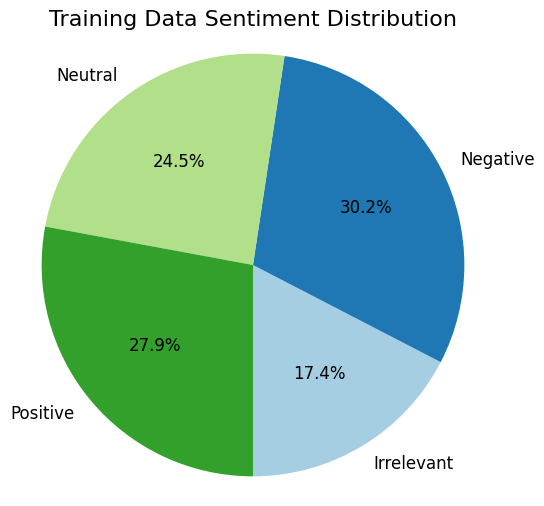

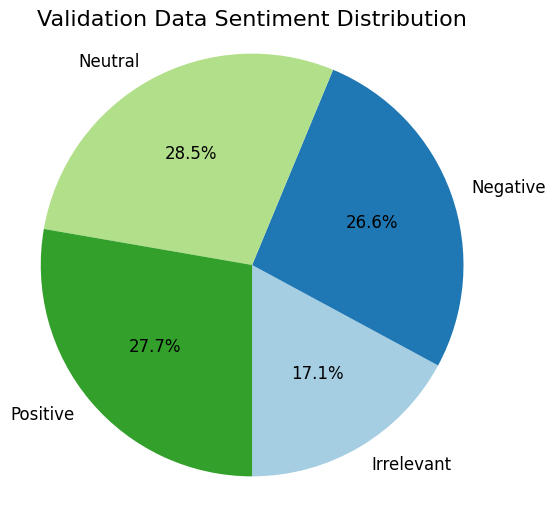

In [17]:
import matplotlib.pyplot as plt

def display_sentiment_pie(data, column, title="Sentiment Distribution"):
   
    # Count occurrences of each sentiment
    sentiment_counts = data.groupby(column).size()

    # Create a pie chart
    fig = plt.figure(figsize=(6, 6), dpi=100)
    ax = plt.subplot(111)
    
    sentiment_counts.plot.pie(
        ax=ax, 
        autopct='%1.1f%%',         # Show percentage
        startangle=270,            # Start angle for the first slice
        fontsize=12,               # Font size for labels
        labels=sentiment_counts.index,  # Use sentiment labels as pie labels
        colors=plt.cm.Paired.colors # Distinct colors for each category
    )

    # Add title
    ax.set_title(title, fontsize=16)

    # Ensure the pie chart is circular
    plt.axis('equal')
    
    # Remove legend to avoid redundancy
    ax.legend().set_visible(False)

    # Show the pie chart
    plt.show()

# Example usage with train_data
display_sentiment_pie(train_data, 'sentiment', title="Training Data Sentiment Distribution")
display_sentiment_pie(val_data, 'sentiment', title="Validation Data Sentiment Distribution")



# **let's create some wordclouds to see which words are the most used for each sentiment:**

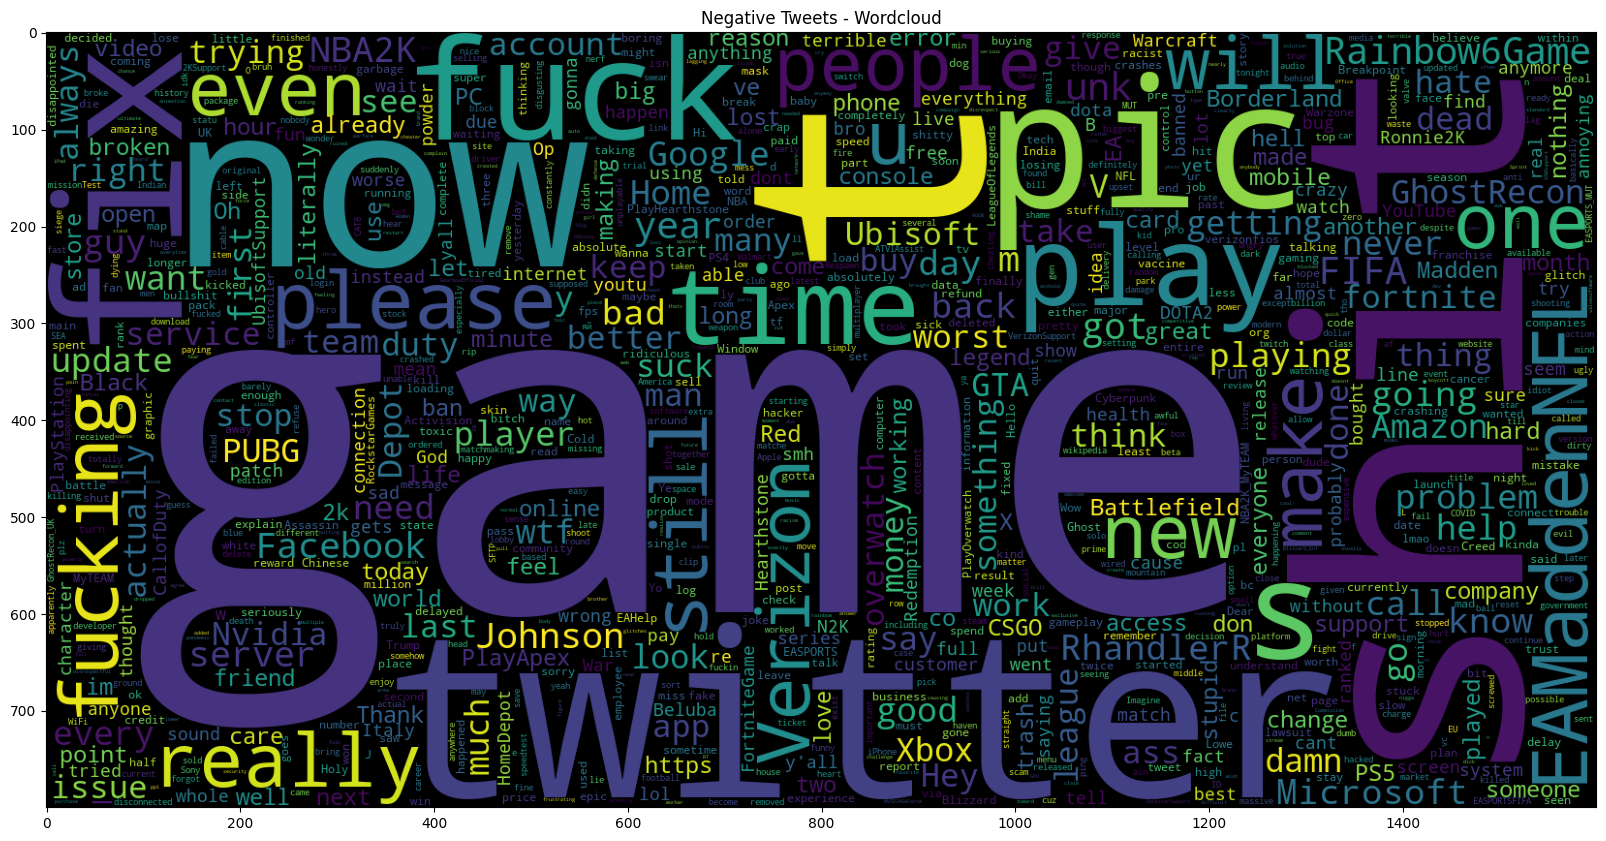

In [18]:
# Plot a cloud of words for negative tweets
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(train_data[train_data["sentiment"]=="Negative"].text))
plt.title("Negative Tweets - Wordcloud")
plt.imshow(wc)

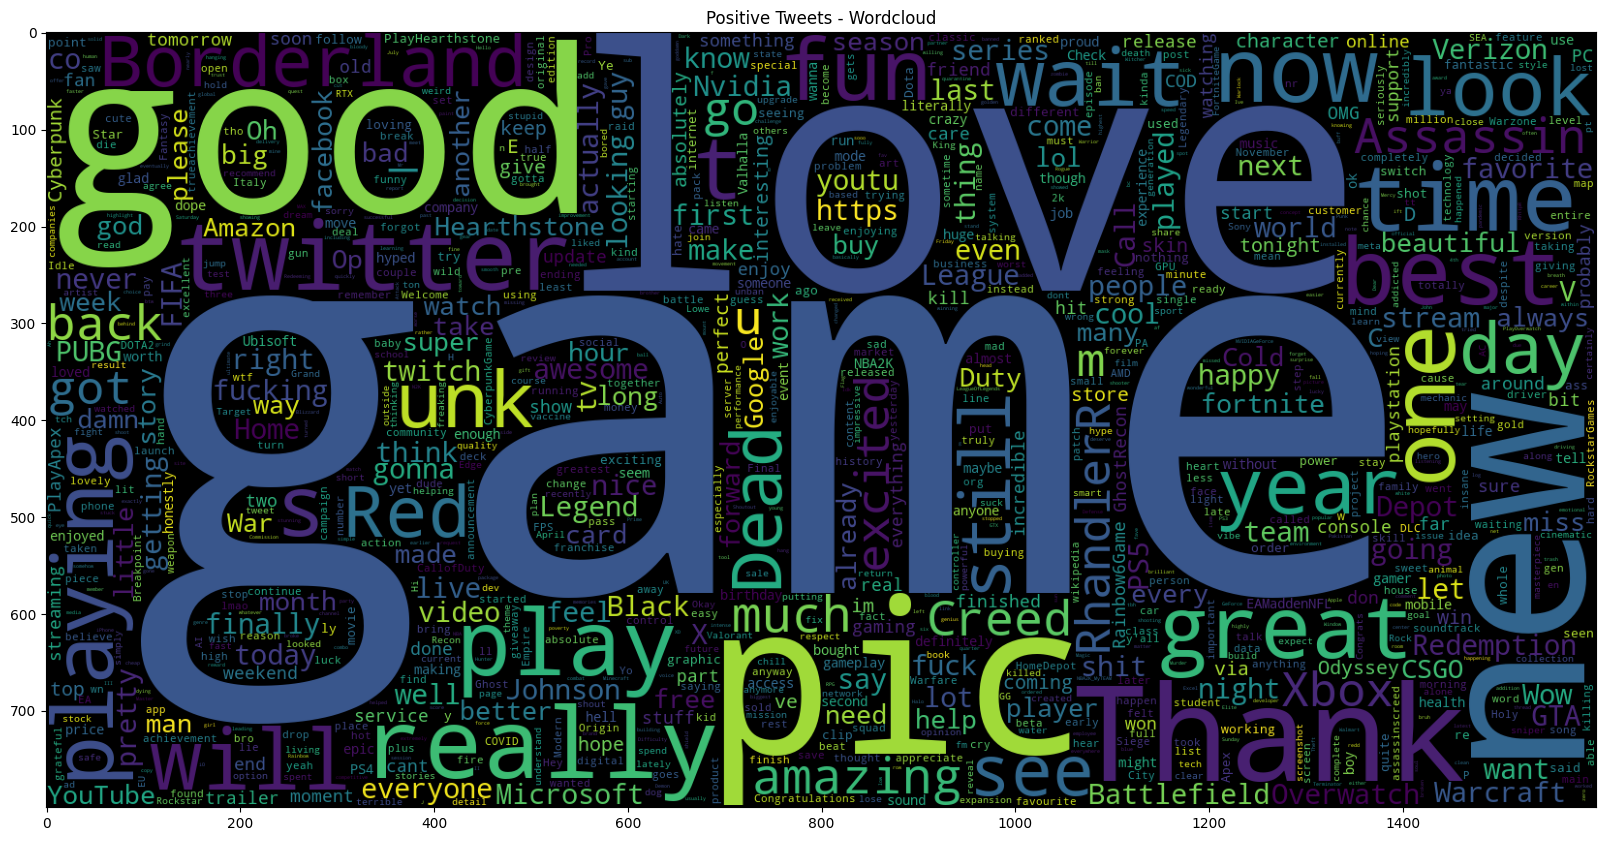

In [19]:
# Plot a cloud of words for positive tweets
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(train_data[train_data["sentiment"]=="Positive"].text))
plt.title("Positive Tweets - Wordcloud")
plt.imshow(wc)

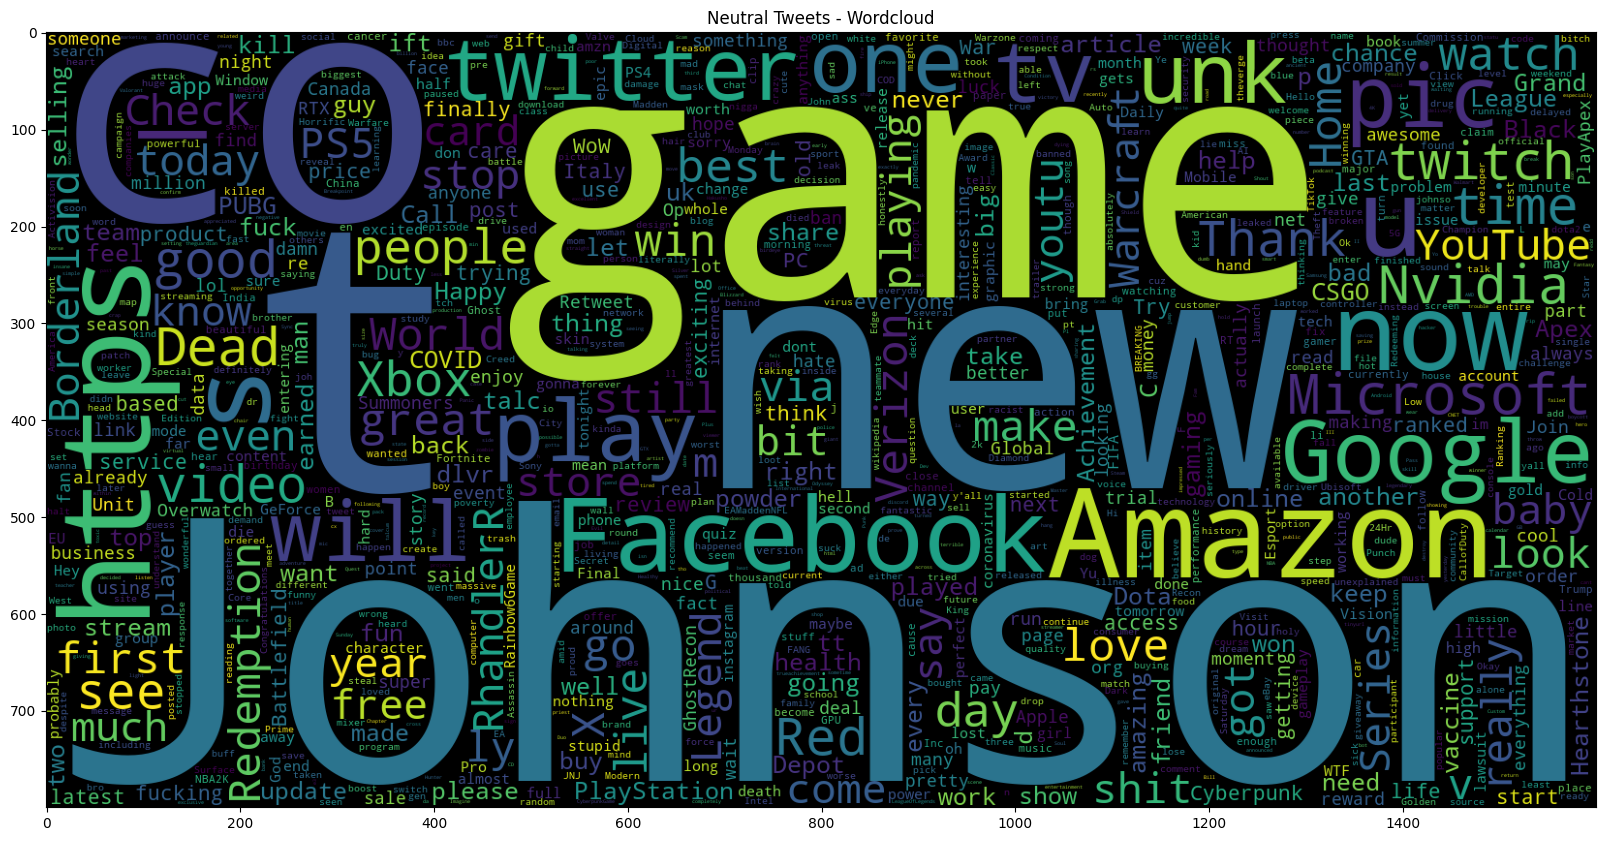

In [20]:
# Plot a cloud of words for Neutral tweets
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(train_data[train_data["sentiment"]=="Neutral"].text))
plt.title("Neutral Tweets - Wordcloud")
plt.imshow(wc)

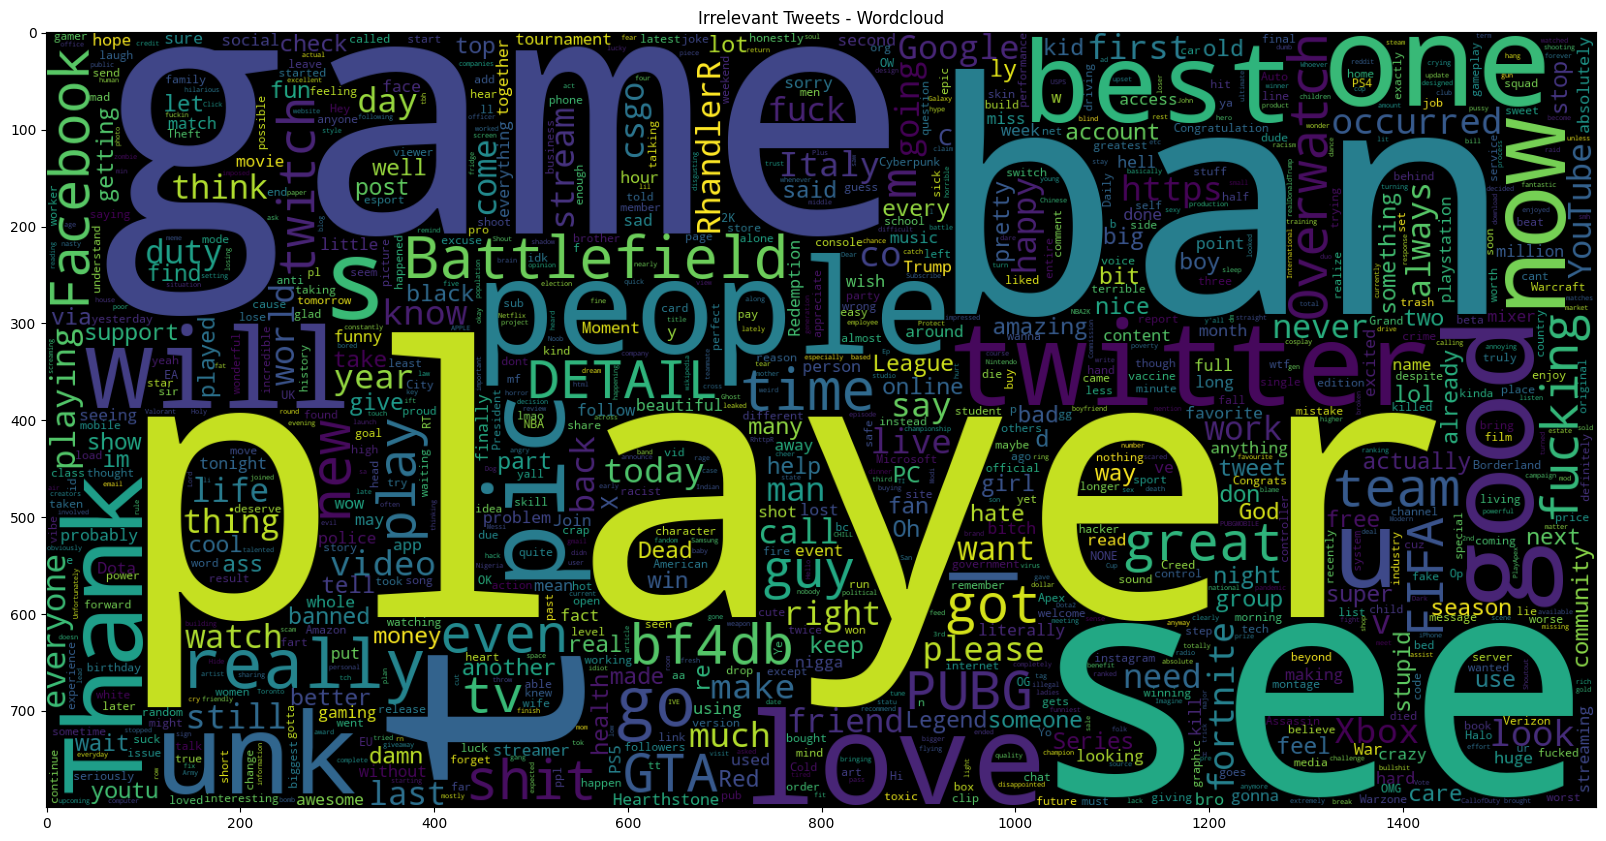

In [21]:
# Plot a cloud of words for Irrelevant tweets
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(train_data[train_data["sentiment"]=="Irrelevant"].text))
plt.title("Irrelevant Tweets - Wordcloud")
plt.imshow(wc)

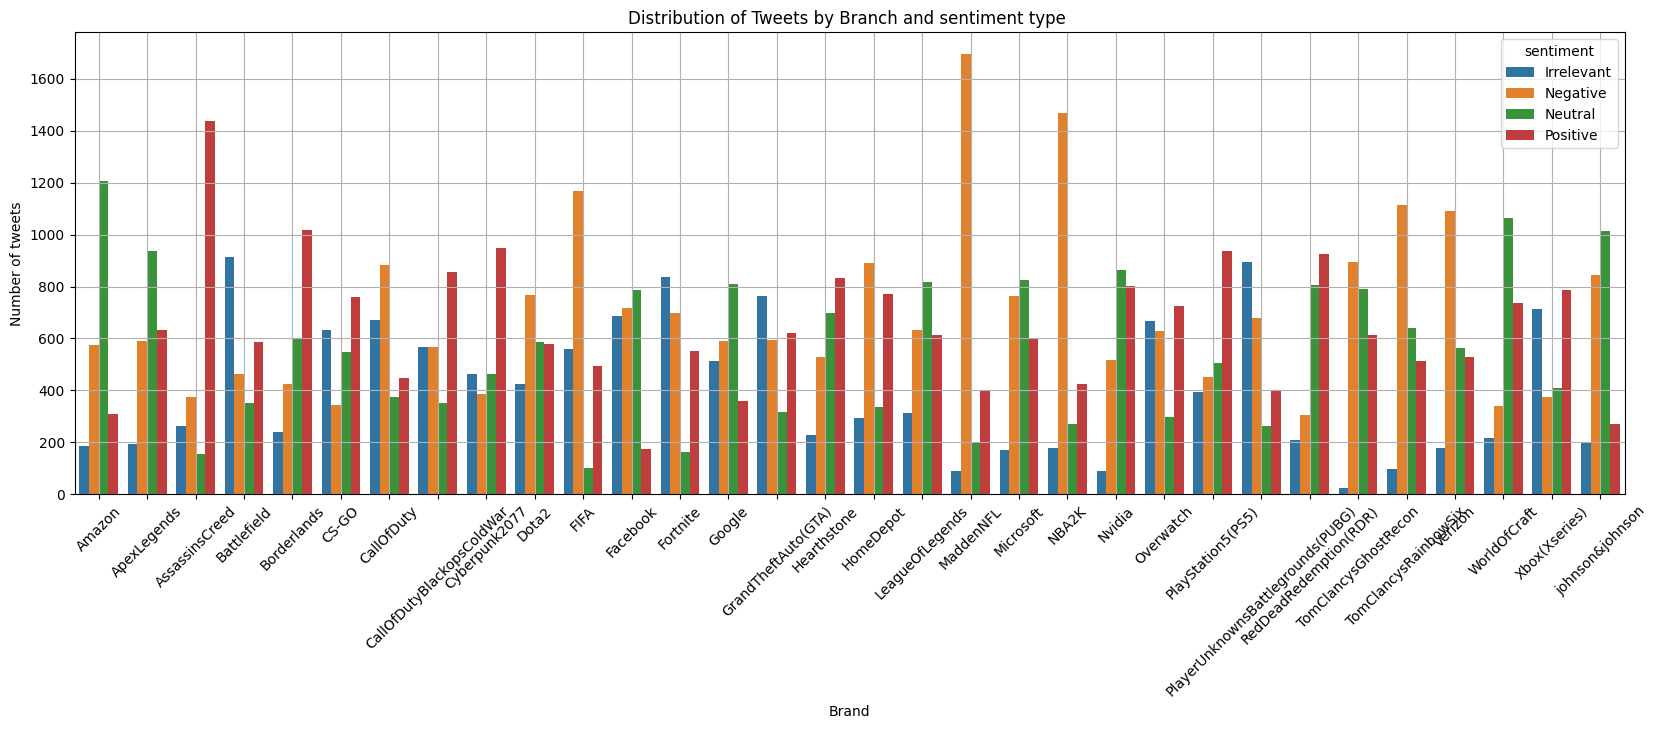

In [22]:
#Count information per category
plot=train_data.groupby(by=["brand","sentiment"]).count().reset_index()
#Figure of comparison per branch
plt.figure(figsize=(20,6))
sns.barplot(data=plot,x="brand",y="id",hue="sentiment")
plt.xticks(rotation=45)
plt.xlabel("Brand")
plt.ylabel("Number of tweets")
plt.grid()
plt.title("Distribution of Tweets by Branch and sentiment type ");

In [26]:

train_data["lower"]=train_data.text.str.lower() #lowercas
train_data.tail()

id   brand sentiment  \
74676  9200  Nvidia  Positive   
74677  9200  Nvidia  Positive   
74678  9200  Nvidia  Positive   
74679  9200  Nvidia  Positive   
74680  9200  Nvidia  Positive   

                                                    text  \
74676  just realized that the windows partition of my...   
74677  just realized that my mac window partition is ...   
74678  just realized the windows partition of my mac ...   
74679  just realized between the windows partition of...   
74680  just like the windows partition of my mac is l...   

                                                   lower  
74676  just realized that the windows partition of my...  
74677  just realized that my mac window partition is ...  
74678  just realized the windows partition of my mac ...  
74679  just realized between the windows partition of...  
74680  just like the windows partition of my mac is l...

In [99]:
val_data["lower"]=train_data.text.str.lower() #lowercas
train_data.tail()

id   brand sentiment  \
74676  9200  Nvidia  Positive   
74677  9200  Nvidia  Positive   
74678  9200  Nvidia  Positive   
74679  9200  Nvidia  Positive   
74680  9200  Nvidia  Positive   

                                                    text  \
74676  just realized that the windows partition of my...   
74677  just realized that my mac window partition is ...   
74678  just realized the windows partition of my mac ...   
74679  just realized between the windows partition of...   
74680  just like the windows partition of my mac is l...   

                                                   lower  
74676  just realized that the windows partition of my...  
74677  just realized that my mac window partition is ...  
74678  just realized the windows partition of my mac ...  
74679  just realized between the windows partition of...  
74680  just like the windows partition of my mac is l...

In [29]:
#Text splitting
tokens_text = [word_tokenize(str(word)) for word in train_data.lower]
#Unique word counter
tokens_counter = [item for sublist in tokens_text for item in sublist]
print("Number of tokens: ", len(set(tokens_counter)))

Number of tokens:  43366


In [32]:
tokens_text[2]


['im',
 'coming',
 'on',
 'borderlands',
 'and',
 'i',
 'will',
 'murder',
 'you',
 'all',
 ',']

In [34]:
#Choosing english stopwords
stopwords_nltk = nltk.corpus.stopwords
stop_words = stopwords_nltk.words('english')
stop_words[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

# Approach 1 : Convert textual data( tweets) into numerical representations using the Bag of Words (BoW) approach

In [37]:
#Initial Bag of Words
bow_counts = CountVectorizer(
    tokenizer=word_tokenize,
    stop_words=stop_words, #English Stopwords
    ngram_range=(1, 1) #analysis of one word
)

**Split train Data into train and test**

In [38]:
# Features (X): 'information' and 'text'
X = train_data[['brand', 'lower']]
# Target (y): 'type'
y = train_data['sentiment']
# Separating the 90% data for training data and 10% for testing data
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=0)

In [39]:
#Creation of encoding related to train dataset
X_train_bow = bow_counts.fit_transform(X_train.lower)
#Transformation of test dataset with train encoding
X_test_bow = bow_counts.transform(X_test.lower)

/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  warnings.warn(


In [44]:
#Total of registers per category
y_test.value_counts() / y_test.shape[0]

sentiment
Negative      0.301304
Positive      0.282114
Neutral       0.245625
Irrelevant    0.170957
Name: count, dtype: float64

In [69]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

def model_Evaluate(model):
    # Predict values for Test dataset
    y_pred = model.predict(X_test_bow)
    
    # Print the evaluation metrics for the dataset
    print(classification_report(y_test, y_pred))
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)
    
    # Define categories
    categories = ['Negative', 'Positive', 'Irrelevant', 'Neutral']
    
    # Create labels for the heatmap (without percentages)
    labels = [f'{v1}' for v1 in cf_matrix.flatten()]
    
    # Reshape labels to match the shape of confusion matrix
    labels = np.asarray(labels).reshape(cf_matrix.shape[0], cf_matrix.shape[1])
    
    # Plot heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cf_matrix, annot=labels, cmap='Blues', fmt='', 
                xticklabels=categories, yticklabels=categories)
    
    plt.xlabel("Predicted values", fontdict={'size': 14}, labelpad=10)
    plt.ylabel("Actual values", fontdict={'size': 14}, labelpad=10)
    plt.title("Confusion Matrix", fontdict={'size': 18}, pad=20)
    plt.show()


              precision    recall  f1-score   support

  Irrelevant       0.91      0.52      0.66      2530
    Negative       0.74      0.82      0.78      4459
     Neutral       0.86      0.56      0.68      3635
    Positive       0.61      0.88      0.72      4175

    accuracy                           0.72     14799
   macro avg       0.78      0.70      0.71     14799
weighted avg       0.76      0.72      0.72     14799



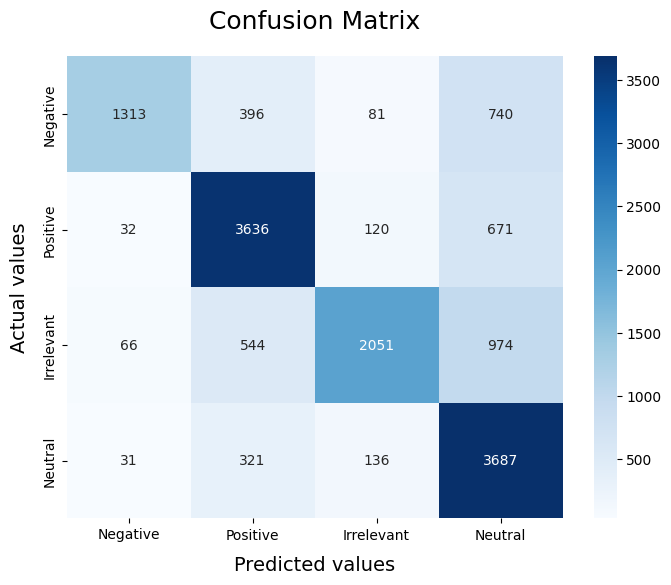

In [60]:
BNBmodel = BernoulliNB()
BNBmodel.fit(X_train_bow, y_train)
model_Evaluate(BNBmodel)
y_pred1 = BNBmodel.predict(X_test_bow)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

  Irrelevant       0.71      0.62      0.66      2530
    Negative       0.76      0.79      0.77      4459
     Neutral       0.73      0.66      0.69      3635
    Positive       0.69      0.78      0.73      4175

    accuracy                           0.72     14799
   macro avg       0.72      0.71      0.71     14799
weighted avg       0.72      0.72      0.72     14799



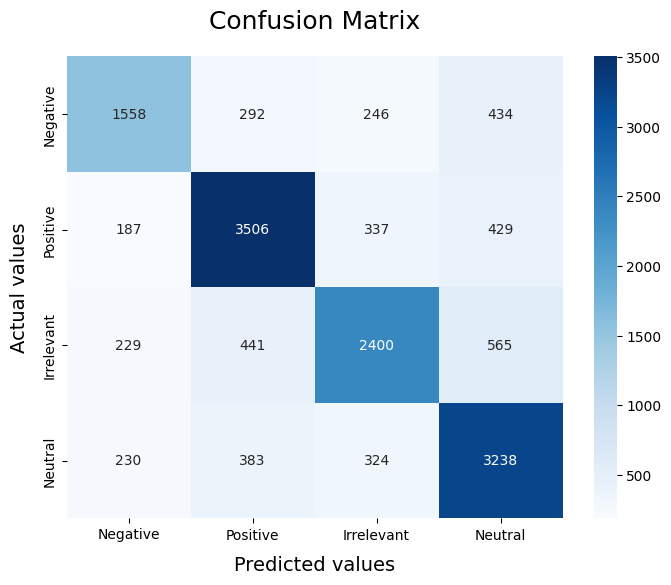

In [70]:
# Logistic regression
Regmodel = LogisticRegression()
Regmodel.fit(X_train_bow, y_train)
model_Evaluate(Regmodel)
# Prediction
y_pred1 = Regmodel.predict(X_test_bow)


# Approach 2 : TF-IDF (Term Frequency-Inverse Document Frequency) vectorizer is a powerful technique used to transform text data into numerical representations while accounting for the importance of each word in relation to the entire corpus.

In [71]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

def model_Evaluate(model):
    # Predict values for Test dataset
    y_pred = model.predict(X_test_lower)
    
    # Print the evaluation metrics for the dataset
    print(classification_report(y_test, y_pred))
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)
    
    # Define categories
    categories = ['Negative', 'Positive', 'Irrelevant', 'Neutral']
    
    # Create labels for the heatmap (without percentages)
    labels = [f'{v1}' for v1 in cf_matrix.flatten()]
    
    # Reshape labels to match the shape of confusion matrix
    labels = np.asarray(labels).reshape(cf_matrix.shape[0], cf_matrix.shape[1])
    
    # Plot heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cf_matrix, annot=labels, cmap='Blues', fmt='', 
                xticklabels=categories, yticklabels=categories)
    
    plt.xlabel("Predicted values", fontdict={'size': 14}, labelpad=10)
    plt.ylabel("Actual values", fontdict={'size': 14}, labelpad=10)
    plt.title("Confusion Matrix", fontdict={'size': 18}, pad=20)
    plt.show()


In [63]:
# Transforming the Dataset Using TF-IDF Vectorizer
vectorizer = TfidfVectorizer()
X_train_lower = vectorizer.fit_transform(X_train['lower'])  # Vectorize lower
X_test_lower = vectorizer.transform(X_test['lower'])        # Vectorize test lower

              precision    recall  f1-score   support

  Irrelevant       0.88      0.55      0.68      2530
    Negative       0.75      0.78      0.77      4459
     Neutral       0.88      0.59      0.70      3635
    Positive       0.60      0.89      0.72      4175

    accuracy                           0.72     14799
   macro avg       0.78      0.70      0.72     14799
weighted avg       0.76      0.72      0.72     14799



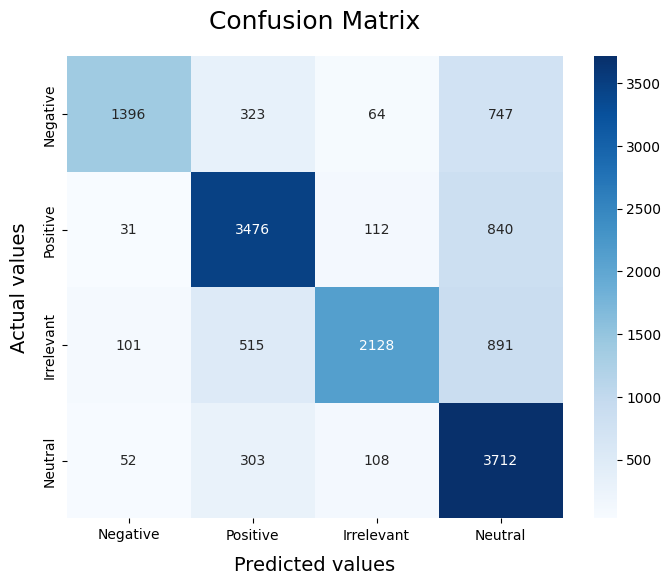

In [66]:
BNBmodel = BernoulliNB()
BNBmodel.fit(X_train_lower, y_train)
model_Evaluate(BNBmodel)
y_pred = BNBmodel.predict(X_test_lower)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

  Irrelevant       0.80      0.68      0.73      2530
    Negative       0.78      0.86      0.82      4459
     Neutral       0.77      0.74      0.75      3635
    Positive       0.78      0.79      0.79      4175

    accuracy                           0.78     14799
   macro avg       0.78      0.77      0.77     14799
weighted avg       0.78      0.78      0.78     14799



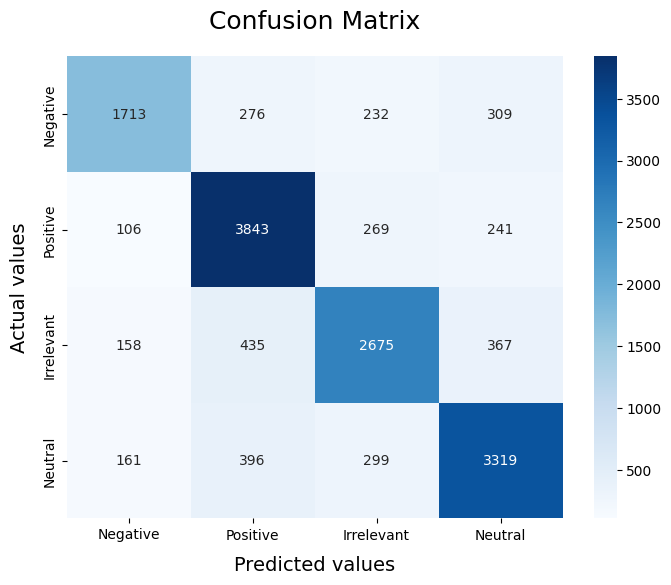

In [67]:
# Logistic regression
Regmodel = LogisticRegression()
Regmodel.fit(X_train_lower, y_train)
model_Evaluate(Regmodel)
# Prediction
y_pred1 = Regmodel.predict(X_test_lower)


**- The Bernoulli Naive Bayes model performed similarly with both representations(Bow and TD-IDF), indicating its robustness with the features provided.**

**- The Logistic Regression model benefitted from using TF-IDF, showing a marked improvement in all metrics. This suggests that TF-IDF may capture the importance of words in a way that enhances classification performance for this specific dataset.**